<a href="https://colab.research.google.com/github/SikiruKilaniOlanrewaju/Network-Intrusion-System/blob/main/IYANDA_NETWORK_INTRUSSION_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>NETWORK INTRUSION DETECTION</h1><br><hr>
BY <br>
<h2><b>IYANDA SEGUN</h2>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'network-intrusion-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F62266%2F120152%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241010%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241010T084106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1802ae334ba5f16d95c559e8ec2f22b8fb9440aded90ca314fd175fef8fb892cf750443c65eff74e398d978551ba1ab22e1b11aaffcebe814fa29c3f7622ab0c079d515a426484810ddc6e26fded4e834ae9f142136623f450460189d55c6098328e93cb47906a90fc320778bfc31e1da0ff2131c9e01e77081922cb955443e8e91958f2eb807f0277604dfe5c0d7cebbc3b8ccbc20460cc7811c1b797b84998f077491de9aaadaf835834f77b1afe5d46aec6e0e836fb923504abd102d1199f43378e75b2c32f791dc5f0db158e5a805e7496071681ae4e8a933c6abfa21bc0df9cce94c6a23e610e8869521ab628206a60c9283bf1d6557e5fdd2fc5d43861'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 838086 bytes downloaded
Downloaded and uncompressed: network-intrusion-detection
Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install optuna

In [ ]:
pip install catboost

# Imports & Configs

In [ ]:
%pip install numpy pandas seaborn matplotlib optuna sklearn xgboost catboost lightgbm > /dev/null 2>&1

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/kaggle/input/network-intrusion-detection/Train_data.csv
/kaggle/input/network-intrusion-detection/Test_data.csv


# Data Preprocessing & EDA

In [ ]:
train=pd.read_csv('/kaggle/input/network-intrusion-detection/Train_data.csv')
test=pd.read_csv('/kaggle/input/network-intrusion-detection/Test_data.csv')
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


## Missing Data

In [ ]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values

## Duplicates

In [ ]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


Great! No duplicates

## Outliers

In [ ]:
# for col in df:
#     if col != 'class' and is_numeric_dtype(df[col]):
#         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#         g1 = sns.boxplot(x = df[col], ax=ax[0])
#         g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
#         plt.show()

No outliers

In [ ]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

# import plotly.express as px
# fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
# fig.show()

ValueError: could not convert string to float: 'tcp'

<Figure size 4000x3000 with 0 Axes>

<Axes: xlabel='class', ylabel='count'>

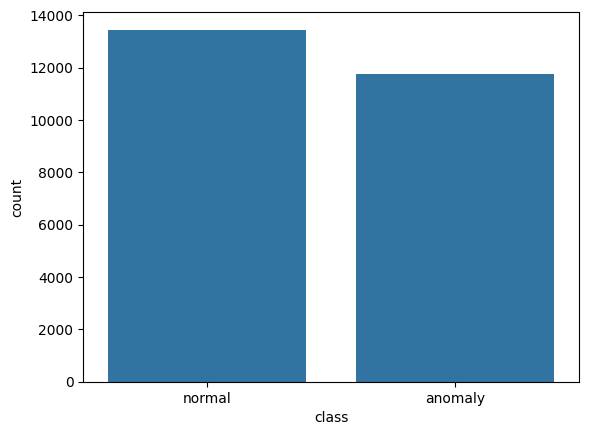

In [ ]:
sns.countplot(x=train['class'])

# Label Encoding

In [ ]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


# Feature selection

In [ ]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [ ]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [ ]:
X_train = X_train[selected_features]

# Split and scale data

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# K Nearest Neighbors (KNN) classification model

In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9814765811061127], datetime_start=datetime.datetime(2024, 10, 10, 9, 33, 23, 701461), datetime_complete=datetime.datetime(2024, 10, 10, 9, 33, 24, 775195), params={'KNN_n_neighbors': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.983327662470228
Test Score: 0.9814765811061127


# Logistic Regression Model

In [ ]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9288873766587274
Test Score: 0.9233924318602805


# Decision Tree Classifier

In [ ]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.9958983858163535], datetime_start=datetime.datetime(2024, 10, 10, 9, 34, 3, 761005), datetime_complete=datetime.datetime(2024, 10, 10, 9, 34, 3, 912316), params={'dt_max_depth': 14, 'dt_max_features': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=22, value=None)


In [ ]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9997731654757854
Test Score: 0.9924583223074888


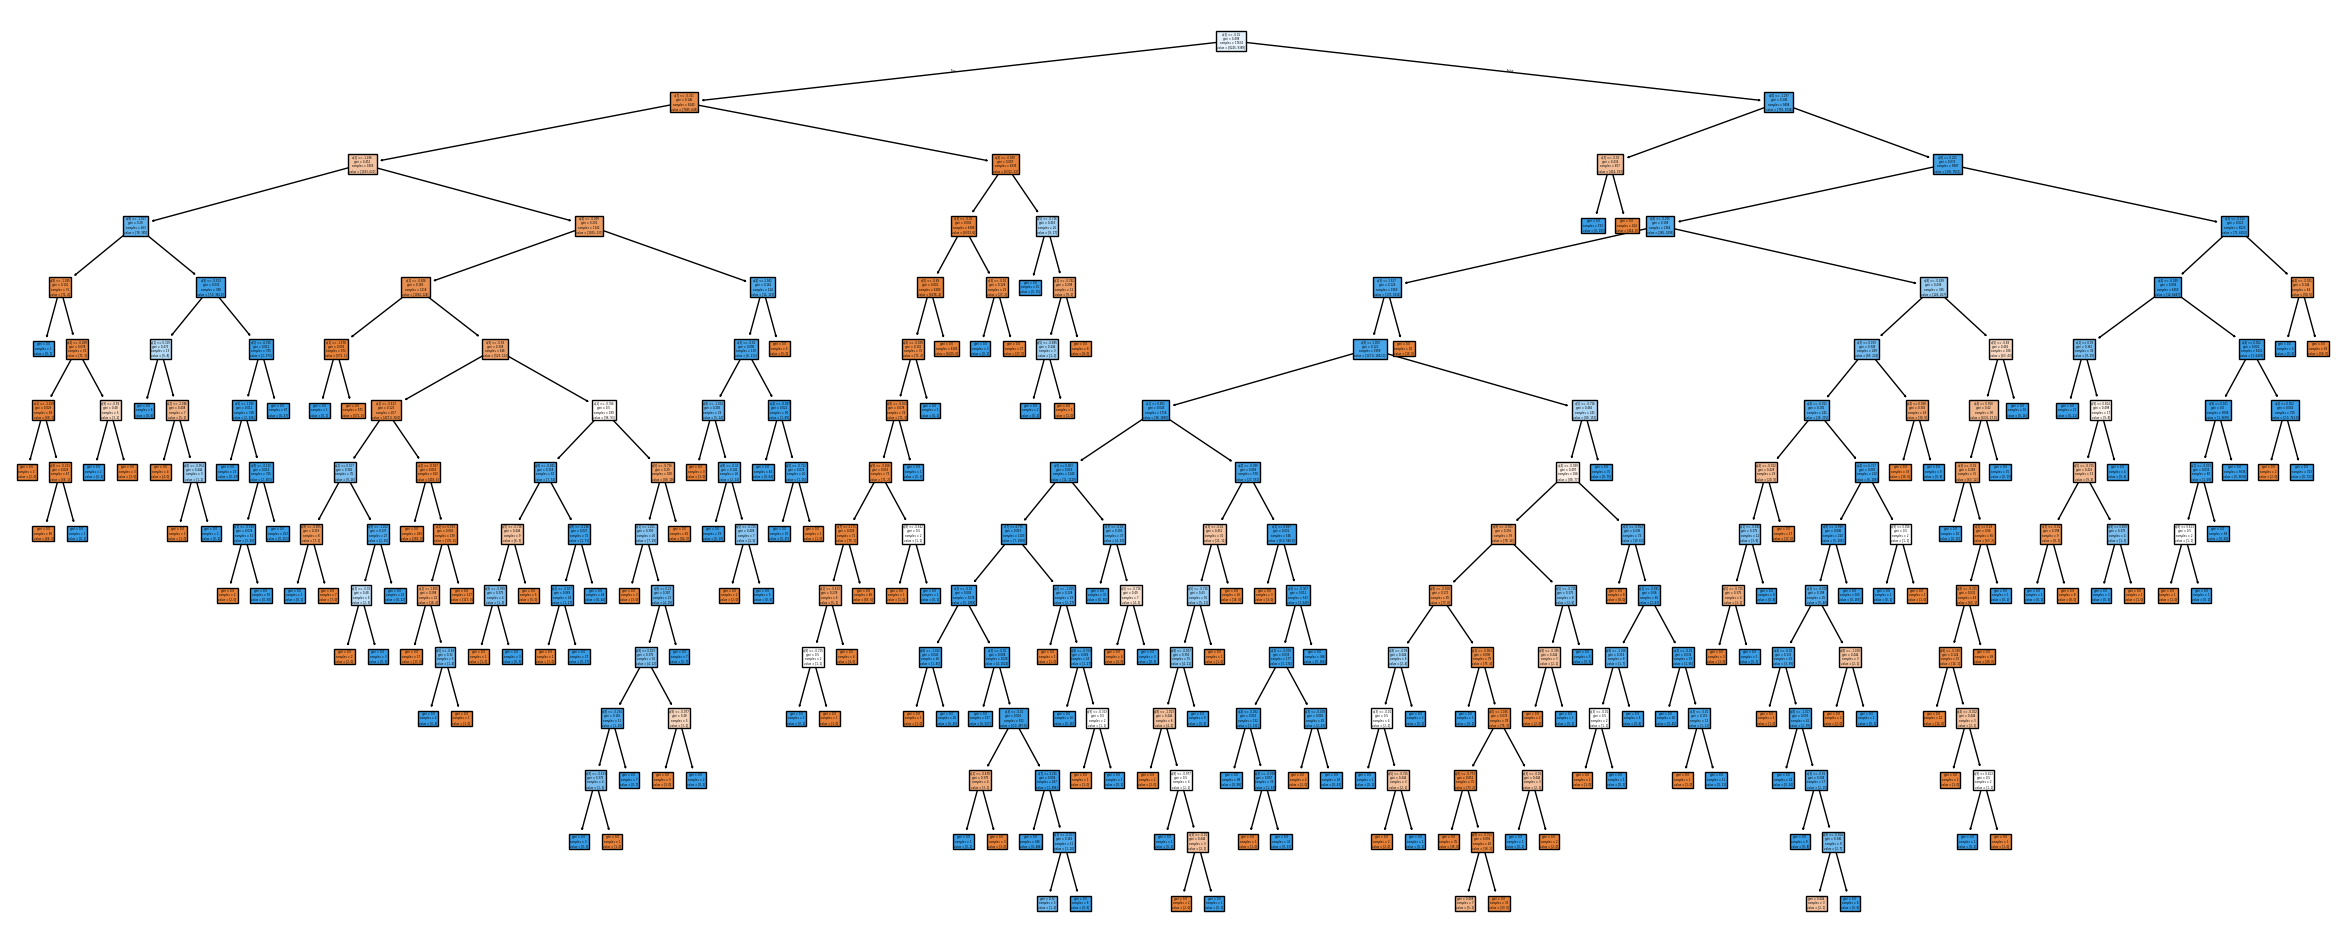

In [ ]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

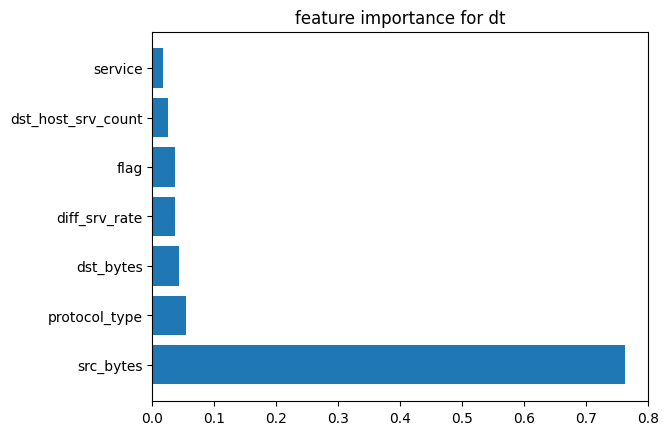

In [ ]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function
# if you are interested in negative contribution of features
f_importance(abs(dt.feature_importances_), features_names, top=7)

# Random Forest Classifier

In [ ]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9965599364911352], datetime_start=datetime.datetime(2024, 10, 10, 9, 34, 57, 710301), datetime_complete=datetime.datetime(2024, 10, 10, 9, 34, 59, 160771), params={'rf_max_depth': 15, 'rf_max_features': 4, 'rf_n_estimators': 18}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=3, value=None)


In [ ]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 0.9998865827378927
Test Score: 0.9961630060862662


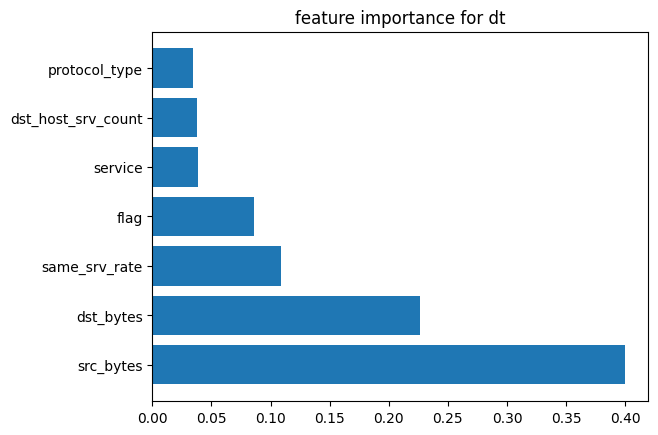

In [ ]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function
# if you are interested in negative contribution of features
f_importance(abs(rf.feature_importances_), features_names, top=7)

# SKLearn Gradient Boosting Model

In [ ]:
SKGB = GradientBoostingClassifier(random_state=42)
SKGB.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
SKGB_train, SKGB_test = SKGB.score(x_train , y_train), SKGB.score(x_test , y_test)

print(f"Training Score: {SKGB_train}")
print(f"Test Score: {SKGB_test}")

Training Score: 0.9947828059430646
Test Score: 0.9927229425774015


# XGBoost Gradient Boosting Model

In [ ]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 1.0
Test Score: 0.9960306959513099


# Light Gradient Boosting Model

In [ ]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [ ]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 1.0
Test Score: 0.9965599364911352


# SKLearn AdaBoost Model

In [ ]:
ab_model = AdaBoostClassifier(random_state=42)

In [ ]:
ab_model.fit(x_train, y_train)

AdaBoostClassifier(random_state=42)

In [ ]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.9800385618691165
Test Score: 0.9790949986768986


# CatBoost Classifier Model

In [ ]:
cb_model = CatBoostClassifier(verbose=0)

In [ ]:
cb_model.fit(x_train, y_train)

In [ ]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9985822842236588
Test Score: 0.9956337655464409


# Naive Baye Model

In [ ]:
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)

BernoulliNB()

In [ ]:
BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8975842123171147
Test Score: 0.8970627150039693


# Voting Model

In [ ]:
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")

In [ ]:
v_clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=9)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x7a90f02b6470>)])

In [ ]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 0.9998865827378927
Test Score: 0.9962953162212226


# Summary

In [ ]:
data = [["KNN", KNN_train, KNN_test],
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test],
        ["Random Forest", rf_train, rf_test],
        ["GBM", SKGB_train, SKGB_test],
        ["XGBM", xgb_train, xgb_test],
        ["Adaboost", ab_train, ab_test],
        ["light GBM", lgb_train, lgb_test],
        ["CatBoost", cb_train, cb_test],
        ["Naive Baye Model", BNB_train, BNB_test],
        ["Voting", voting_train, voting_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.983328 │     0.981477 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.928887 │     0.923392 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999773 │     0.992458 │
├─────────────────────┼───────────────┼──────────────┤
│ Random Forest       │      0.999887 │     0.996163 │
├─────────────────────┼───────────────┼──────────────┤
│ GBM                 │      0.994783 │     0.992723 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      1        │     0.996031 │
├─────────────────────┼───────────────┼──────────────┤
│ Adaboost            │      0.980039 │     0.979095 │
├─────────────────────┼───────────────┼──────────────┤
│ light GBM           │      1        │     0.99656  │
├─────────